# This notebook is to read the CLAGNs from the literature with their redshifts and types
Last edit: Oct 4th, 2023

In [ ]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import table
from astropy.table import Table, join, join_skycoord
from astroquery.ipac.ned import Ned
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
import sys
sys.path.append('../code/')
from sample_selection import clean_sample
from sample_lc import parallel_lc

In [ ]:
# LaMassa 2015, Macleod 2016
macleod_CSQ = Table.read('https://academic.oup.com/mnras/article/457/1/389/989199', htmldict={'table_id': 5}, format='ascii.html')
coord_str = macleod_CSQ['Name\n            .'][0]
test_str = coord_str[0:2]+ " "+ coord_str[2:4]+ " " + coord_str[4:9] + " " + coord_str[9:12] + " " + coord_str[12:14]+ " " + coord_str[14:]
c = SkyCoord(test_str, unit=(u.hourangle, u.deg))
d={'ra':[c.ra.degree],'dec':[c.dec.degree],'redshift':[macleod_CSQ['z\n            .'][0]],'turnon':[1]}

k=1
ton,toff = 1,0
for i in range(1,len(macleod_CSQ)):
    coord_str = macleod_CSQ['Name\n            .'][i]
    test_str = coord_str[0:2]+ " "+ coord_str[2:4]+ " " + coord_str[4:9] + " " + coord_str[9:12] + " " + coord_str[12:14]+ " " + coord_str[14:]
    c = SkyCoord(test_str, unit=(u.hourangle, u.deg))
    d['ra'].append(c.ra.degree)
    d['dec'].append(c.dec.degree)
    d['redshift'].append(macleod_CSQ['z\n            .'][i])
    label = macleod_CSQ['BEL\n            .'][i]
    if label=='Appear':
        d['turnon'].append(1)
        ton+=1
    else:
        d['turnon'].append(0)  
        toff+=1
    k+=1
print(str(k)+' added, turn_on=',str(ton)+', turn_off='+str(toff))        

In [ ]:
# Ruan 2016
ruan_CSQ = Ned.query_refcode('2016ApJ...826..188R')
ruan_coords = [SkyCoord(ra, dec, frame='icrs', unit='deg') for ra, dec in zip(ruan_CSQ['RA'], ruan_CSQ['DEC'])]
k=0
ton,toff = 0,0

for i in range(len(ruan_CSQ['RA'])):
    coord = SkyCoord(ruan_coords[i], unit=(u.hourangle, u.deg))
    d['ra'].append(coord.ra.degree)
    d['dec'].append(coord.dec.degree)
    d['redshift'].append(ruan_CSQ['Redshift'][i])
    d['turnon'].append(0)
    k+=1
    toff+=1

print(str(k)+' added, turn_on=',str(ton)+', turn_off='+str(toff))        

In [ ]:
#Yang 2018
CLQ = np.genfromtxt('yangg.cat', dtype=[('SDSSid', 'S18'), ('RA', 'S18'), ('DEC', 'S18'),
                                        ('Redshift','<f8'),('Transition','S18')])
k=0
ton,toff = 0,0
for i in range(len(CLQ['RA'])):
    ra = CLQ['RA'][i].decode('utf8')
    dec = CLQ['DEC'][i].decode('utf8')    
    c = SkyCoord(ra+dec, unit=(u.hourangle, u.deg))
    d['ra'].append(c.ra.degree)
    d['dec'].append(c.dec.degree)
    d['redshift'].append(CLQ['Redshift'][i])
    if CLQ['Transition'][i]==b'Turn-on':
        d['turnon'].append(1)
        ton+=1
    else:
        d['turnon'].append(0)
        toff+=1

    k+=1
print(str(k)+' added, turn_on=',str(ton)+', turn_off='+str(toff))        

In [ ]:
# MacLeod2019
a = np.genfromtxt('table2.dat', dtype=[('SDSSid', 'S18'), ('redshift', '<f8'), ('morphology', '<i8'),
                                      ('mjd1', 'S24'), ('mag1', '<f8'),('dmag1', '<f8'),
                                      ('mjd2', 'S24'), ('mag2', '<f8'),('dmag2', '<f8'),
                                      ('mjds', 'S24'), ('mjdps1', 'S24'), ('magps', '<f8'),('dmagps', '<f8'),
                                       ('mjdps2', 'S24'), ('tel', 'S24'), ('clq', '<i8'),('nsigma', '<f8')])
k=0
ton,toff = 0,0

for i in range(len(a['SDSSid'])):
    coord_str = a['SDSSid'][i].decode('utf8')
    test_str = coord_str[0:2]+ " "+ coord_str[2:4]+ " " + coord_str[4:9] + " " + coord_str[9:12] + " " + coord_str[12:14]+ " " + coord_str[14:]
    coords = SkyCoord(test_str, unit=(u.hourangle, u.deg))
    
    d['ra'].append(coords.ra.degree)
    d['dec'].append(coords.dec.degree)
    d['redshift'].append(a['redshift'][i])

    if a['mag1'][i]>a['mag2'][i]:
        d['turnon'].append(1)
        ton+=1

    else:
        d['turnon'].append(0)
        toff+=1

    k+=1
print(str(k)+' added, turn_on=',str(ton)+', turn_off='+str(toff))        

In [ ]:
#Sheng 
CLQ = Ned.query_refcode('2020ApJ...889...46S') 
sheng_CLQ = CLQ[[0,1,2,3,5,6]]#need the first 3 objects in their table, 
sheng_coords = [SkyCoord(ra, dec, frame='icrs', unit='deg') for ra, dec in zip(sheng_CLQ['RA'], sheng_CLQ['DEC'])]
k=0
ton,toff = 0,0
for i in range(len(sheng_CLQ['Redshift'])):
    d['ra'].append(sheng_coords[i].ra.degree)
    d['dec'].append(sheng_coords[i].dec.degree)
    d['redshift'].append(sheng_CLQ['Redshift'][i])
    d['turnon'].append(0)
    k+=1
    toff+=1
    
print(str(k)+' added, turn_on=',str(ton)+', turn_off='+str(toff))        

In [ ]:
#green
Vizier.ROW_LIMIT = -1
catalog_list = Vizier.find_catalogs('J/ApJ/933/180')
catalogs = Vizier.get_catalogs(catalog_list.keys())
table2 = catalogs[0]
green_CSQ = table2.to_pandas()
k=0
ton,toff = 0,0

for i in range(len(green_CSQ)):
    if "CLQ" in (green_CSQ['Notes'][i]):

        d['ra'].append(green_CSQ['_RA'][i])
        d['dec'].append(green_CSQ['_DE'][i])
        d['redshift'].append(green_CSQ['zspec'][i])
        if "TurnOn" in (green_CSQ['Notes'][i]):
            d['turnon'].append(1)
            ton+=1
        else:
            d['turnon'].append(0)
            toff+=1
        k+=1
print(str(k)+' added, turn_on=',str(ton)+', turn_off='+str(toff))        

In [ ]:
#Lyu
CLQ = Ned.query_refcode('2022ApJ...927..227L') 
#CLQ['RA'], CLQ['DEC'], CLQ['Redshift'], CLQ['Type']

In [ ]:
result_table = Simbad.query_bibobj('2022MNRAS.513L..57L')
result_table = result_table[[0,1,2,3]]  #pick the correct sources by hand
result_table.columns

k=0
ton,toff = 0,0
z = [0.1022,0.2375,0.1083,0.0849]
for i in range(len(result_table)):
    d['ra'].append(result_table['RA'][i])
    d['dec'].append(result_table['DEC'][i])
    d['redshift'].append(z[i])
    d['turnon'].append(1)
    ton+=1
    k+=1
print(str(k)+' added, turn_on=',str(ton)+', turn_off='+str(toff))  

In [ ]:
CLQ = Ned.query_refcode('2022MNRAS.511...54H') 
#CLQ.columns
ids = [2,3,5,6,10,11,12,13,16,20,24,25,27,28,14,26]
onoff = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0]
k=0
ton,toff = 0,0
for i,idd in enumerate(ids):    
    d['ra'].append(CLQ['RA'][idd])
    d['dec'].append(CLQ['DEC'][idd])
    d['redshift'].append(CLQ['Redshift'][idd])
    if onoff[i]==1:
        d['turnon'].append(1)
        ton+=1
    else:
        d['turnon'].append(0)
        toff+=1
    k+=1
print(str(k)+' added, turn_on=',str(ton)+', turn_off='+str(toff))  

In [ ]:
df = pd.DataFrame(data=d)
df

In [ ]:
def clean_sample2(skycoordslist, labels, param):

    t = Table([skycoordslist, labels, param, np.arange(0, len(skycoordslist), 1)], names=['sc', 'label','param', 'idx'])

    #now join the table with itself within a defined radius
    tjoin = join(t, t, keys='sc', join_funcs={'sc': join_skycoord(0.005 * u.deg)})
    uniquerows = table.unique(tjoin, keys = 'sc_id')

    #turn back into a list
    raw_coords_list = list(uniquerows['sc_1'])
    labels_list = list(uniquerows['label_1'])
    param_list = list(uniquerows['param_1'])
    coords_list = list(enumerate(raw_coords_list))  # list of tuples (objectid, skycoords)

    return coords_list, labels_list, param_list

In [ ]:
d1 = df[df['turnon']==1]
d0 = df[df['turnon']==0]
print(len(d1),len(d0))

coords = [SkyCoord(ra, dec, frame='icrs', unit='deg') for ra, dec in zip(df['ra'], df['dec'])]
labels=[]
for l in df['turnon']:
    if l==1:
        labels.append('CL-On')
    else:
        labels.append('CL-Off')

c,l,z = clean_sample2(coords,labels,df['redshift'])

In [ ]:
dd = {'labels':l,'redshift':z}
dfs = pd.DataFrame(data=dd)
dfs.to_parquet('clagn_redshifts.parquet')

In [ ]:
#dflc = parallel_lc(c,l,parquet_savename = '../output/df_lc_changelook.parquet')


In [55]:
#!pip install -r requirements.txt
import sys
import os
import re
import time
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import pandas as pd
sys.path.append('../code/')
from data_structures import MultiIndexDFObject
from ML_utils import unify_lc, stat_bands, autopct_format, combine_bands,\
mean_fractional_variation, normalize_mean_objects, normalize_max_objects, \
normalize_clipmax_objects, shuffle_datalabel, dtw_distance, stretch_small_values_arctan
from sample_lc import build_sample
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
try:
    import umap
    import umap.plot
except:
    !pip install umap-learn[plot]

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')
colors = [
    "#FFA500",  # Orange
    "#9370DB",  # Medium Purple
    "#6C907D",  # Soft Green
    "#B9C3C2",  # Pale Gray
    "#8C9EFF",  # Periwinkle Blue
    "#FF6347",  # Tomato Red
    "#66CDAA",  # Medium Aquamarine
    "#E6E6FA",  # Lavender
    "#FAFAD2",  # Light Goldenrod Yellow
    "#FFD700",  # Gold

]

# To build a sample and generate the multiindex lc dataframe the code below is used, which takes long:
#!python sample_lc.py
#c,l = build_sample() # if coordinates and labels of the sample are needed separately

In [56]:
parquet_loadname = '../output/df_lc_changelook.parquet'
parallel_df_lc = MultiIndexDFObject()
parallel_df_lc.data = pd.read_parquet(parquet_loadname)


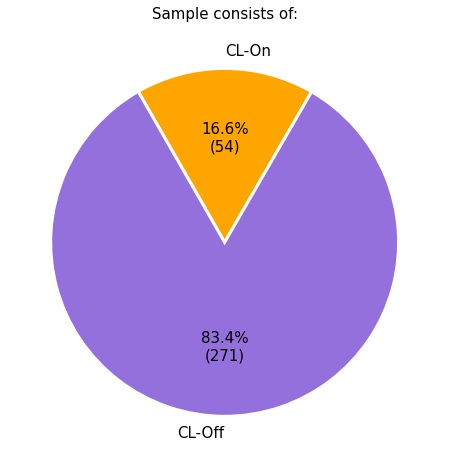

In [57]:
from collections import Counter
objid = parallel_df_lc.data.index.get_level_values('objectid')[:].unique()
seen = Counter()

# Grouping all changing look AGNs from the literature into one class:
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for b in objid:
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    if label in cl_labels:
        label = ['CL AGN']
    if label=='ZTF-Objname':
        label= ['TDE']
    if label=='Cicco19':
        label= ['VLT Cosmos']                
    seen.update(label)

#changing order of labels in dictionary only for text to be readable on the plot
from collections import OrderedDict
key_order = ('CL-On','CL-Off')
new_queue = OrderedDict()
for k in key_order:
    new_queue[k] = seen[k]
    
plt.figure(figsize=(8,8))
plt.title(r'Sample consists of:',size=15)
h = plt.pie(new_queue.values(),labels=new_queue.keys(),autopct=autopct_format(new_queue.values()), textprops={'fontsize': 15},startangle=60,  labeldistance=1.1, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, colors=colors)

0it [00:00, ?it/s]

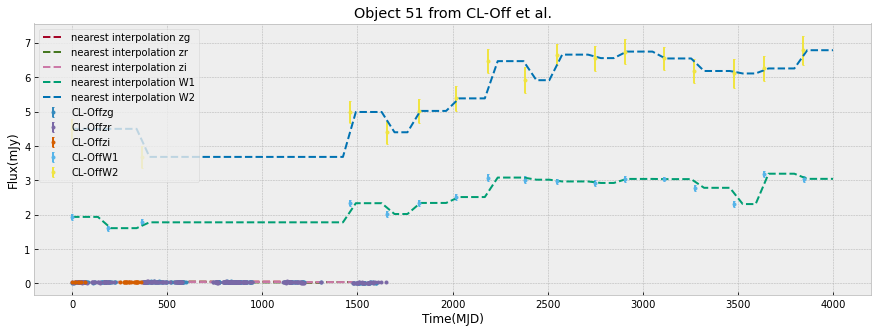

1it [00:00,  2.98it/s]

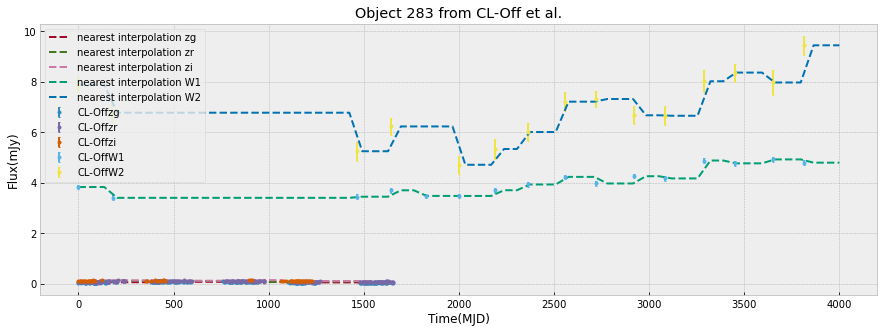

2it [00:00,  2.99it/s]

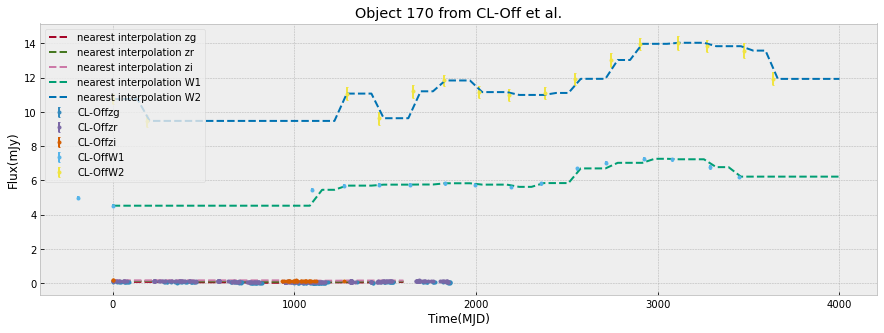

325it [00:03, 100.41it/s]


In [93]:
bands_inlc = ['zg','zr','zi','W1','W2']
objects,dobjects,flabels,keeps = unify_lc(parallel_df_lc,bands_inlc,xres=60,numplots=3)

lz = pd.read_parquet('clagn_redshifts.parquet')
redshifts = np.array(lz['redshift'][keeps])

# calculate some basic statistics
fvar, maxarray, meanarray = stat_bands(objects,dobjects,bands_inlc)

# combine different waveband into one array
dat_notnormal = combine_bands(objects,bands_inlc)

# Normalize the combinde array by maximum of brightness in a waveband after clipping outliers:
dat = normalize_clipmax_objects(dat_notnormal,maxarray,band = -1)

# Normalize the combinde array by mean brightness in a waveband after clipping outliers:
datm = normalize_clipmax_objects(dat_notnormal,meanarray,band = 1)

# shuffle data incase the ML routines are sensitive to order
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr,redshift_arr = fvar[:,p],maxarray[:,p],meanarray[:,p],redshifts[p]

# Fix label of all changing looks and TDEs 
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'

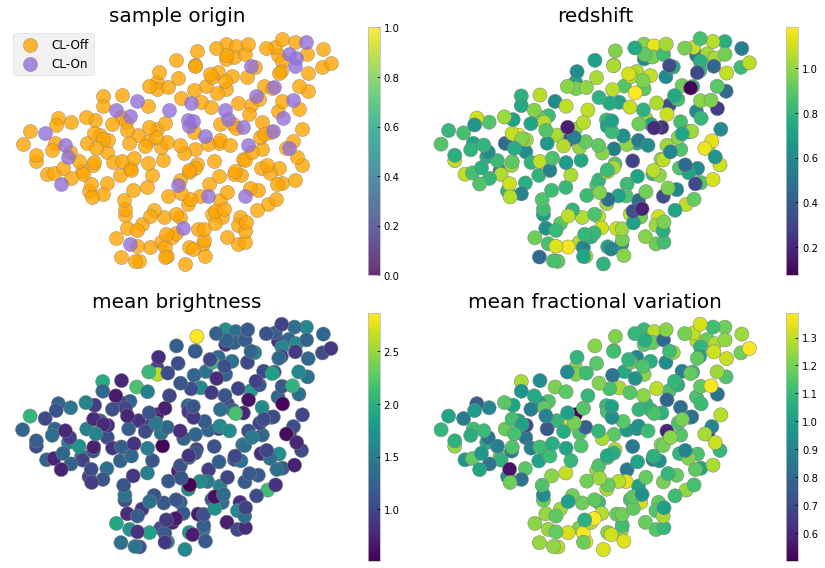

In [94]:
plt.figure(figsize=(12,8))
markersize=200
mapper = umap.UMAP(n_neighbors=50,min_dist=1,metric=dtw_distance,random_state=2).fit(data)

ax1 = plt.subplot(2,2,3)
ax1.set_title(r'mean brightness',size=20)
cf = ax1.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=np.log10(np.nansum(meanarray,axis=0)),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax0 = plt.subplot(2,2,4)
ax0.set_title(r'mean fractional variation',size=20)
cf = ax0.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(np.nansum(fvar_arr,axis=0),factor=3),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax2 = plt.subplot(2,2,1)
ax2.set_title('sample origin',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.8,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.colorbar(cf)
plt.axis('off')


ax0 = plt.subplot(2,2,2)
ax0.set_title(r'redshift',size=20)
cf = ax0.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(redshifts,factor=3),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')


plt.tight_layout()

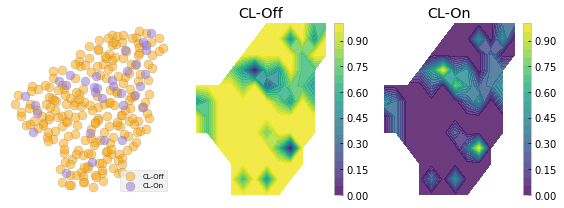

In [95]:
# Calculate 2D histogram
hist, x_edges, y_edges = np.histogram2d(mapper.embedding_[:, 0], mapper.embedding_[:, 1], bins=12)

# Calculate class probabilities for each bin
class_probabilities = []

for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    hist_per_cluster, _, _ = np.histogram2d(mapper.embedding_[u,0], mapper.embedding_[u,1], bins=(x_edges, y_edges))
    class_prob = hist_per_cluster / hist
    class_probabilities.append(class_prob)
    #print(lab, class_prob)

labs = np.unique(fzr)
plt.figure(figsize=(8,3))
ax0 = plt.subplot(1,3,1)
for i, prob in enumerate(class_probabilities):
    plt.subplot(1,3,i+2)
    plt.title(labs[i])
    plt.contourf(x_edges[:-1], y_edges[:-1], prob.T, levels=20, alpha=0.8)
    plt.colorbar()
    plt.axis('off')
    u=(fzr[:]==labs[i])
    cf = ax0.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=80,c=colors[i],alpha=0.5,edgecolor='gray',label=labs[i])
ax0.legend(loc=4,fontsize=7)
ax0.axis('off')
plt.tight_layout()
